In [157]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.width', 500)

In [158]:
csv_file_path = "./project_3.csv"
original_df = pd.read_csv(csv_file_path)
df = original_df.copy()

# Simple Data Exploration over the whole dataset

In [ ]:
df_columns = [column for column in df.columns]
print(df_columns)

In [ ]:
print(df.info())

In [ ]:
print(df.describe())

In [ ]:
missing_values_count = df.isna().sum()
missing_values_count_non_zero = missing_values_count[missing_values_count > 0]
print(f"Number of missing values per column:\n"
      f"{missing_values_count_non_zero}")

In [ ]:
unique_count = []
for column in df.columns:
    ratio_unique_value = len(df[column]) / len(df[column].unique())
    unique_count.append((column, ratio_unique_value))

unique_count.sort(key=lambda x: x[1])

thresholds = [1, 2, 20]  
colors = ['purple', 'red', 'orange', 'green']

color_map = np.digitize([ratio for _, ratio in unique_count], thresholds, right=True)

columns, ratios = zip(*unique_count)
plt.figure(figsize=(10, 10))
bar_plot = plt.barh(columns, ratios, color=[colors[idx] for idx in color_map])
plt.xscale('log')
plt.xlabel('Ratio of Unique Values (log scale)')
plt.ylabel('Columns')
plt.title('Ratio of Unique Values in Each Column')

for i, ratio in enumerate(ratios):
    if ratio > 5 or int(ratio * 100) % 10 == 0:
        text = f'{ratio:.0f}'
    else:
        text = f'{ratio:.2f}'
    plt.text(ratio, i, text, ha='left', va='center', color='black', fontsize=8)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

max_unique_val = 30

valid_columns_count = sum(1 for column_name in df.columns if len(df[column_name].value_counts().index) < 20)

num_rows = (valid_columns_count + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

if num_rows == 1 and num_cols == 1:
    axs = [axs]

subplot_index = 0
for column_name in df.columns:
    unique_values_distribution = df[column_name].value_counts()
    if len(unique_values_distribution.index) < max_unique_val:
        row_index = subplot_index // num_cols
        col_index = subplot_index % num_cols

        axs[row_index, col_index].bar(unique_values_distribution.index, unique_values_distribution.values)
        axs[row_index, col_index].set_title('Column "{}"'.format(column_name))
        axs[row_index, col_index].set_xlabel('Unique Values')
        axs[row_index, col_index].set_ylabel('Count')
        axs[row_index, col_index].tick_params(axis='x', rotation=45)
        axs[row_index, col_index].grid(axis='y', linestyle='--', alpha=0.7)
        
        subplot_index += 1

# Adjust layout
plt.tight_layout()
plt.show()

# String Cleaning 0 / 23

## Normal 0 / 18

In [131]:
def step_1(interested_column):
    print(df[interested_column])
    missing_values_count = df[interested_column].isna().sum()
    print(f'There are {missing_values_count} missing value(s) in the column {interested_column}')

### Unique value 0 / 7

#### lastname ❌  
typing errors (Ba+rett, Ev$ns…) + incomplete> remove special characters.

In [132]:
interested_column = 'lastname'

In [133]:
step_1(interested_column)

0        Figueroa
1           Smith
2       Nicholson
3          Harvey
4         Sanchez
          ...    
9995      Coleman
9996        Dixon
9997      V(zquez
9998       Greene
9999         Wolf
Name: lastname, Length: 10000, dtype: object
There are 0 missing value(s) in the column lastname


In [147]:
def identify_inconsistencies(df):
    inconsistency_types = {}
    inconsistency_count = 0

    # Regular expression pattern to match non-letter characters
    pattern = re.compile(r'[^a-zA-Z]')

    for index, row in df.iterrows():
        lastname = row['lastname']
        if re.search(pattern, lastname):
            inconsistency = re.findall(pattern, lastname)
            inconsistency = ''.join(inconsistency)
            if inconsistency in inconsistency_types:
                inconsistency_types[inconsistency] += 1
            else:
                inconsistency_types[inconsistency] = 1
            inconsistency_count += 1

    return inconsistency_types, inconsistency_count

# Identify and count inconsistencies
inconsistency_types, inconsistency_count = identify_inconsistencies(df)

# Display the summary of inconsistencies
print("Summary of inconsistencies:")
for inconsistency, count in inconsistency_types.items():
    print(f"Inconsistency '{inconsistency}': {count} occurrences")
print("Number of inconsistent last names:", inconsistency_count)

Summary of inconsistencies:
Inconsistency '`': 13 occurrences
Inconsistency '}': 15 occurrences
Inconsistency '~': 15 occurrences
Inconsistency ',': 15 occurrences
Inconsistency '^': 18 occurrences
Inconsistency '!': 19 occurrences
Inconsistency '*': 10 occurrences
Inconsistency '<': 17 occurrences
Inconsistency '#': 13 occurrences
Inconsistency '%': 22 occurrences
Inconsistency '?': 14 occurrences
Inconsistency ''': 15 occurrences
Inconsistency '\\': 19 occurrences
Inconsistency ')': 11 occurrences
Inconsistency '_': 16 occurrences
Inconsistency '(': 17 occurrences
Inconsistency '>': 18 occurrences
Inconsistency ']': 16 occurrences
Inconsistency '/': 26 occurrences
Inconsistency ';': 13 occurrences
Inconsistency '=': 14 occurrences
Inconsistency '{': 14 occurrences
Inconsistency '"': 21 occurrences
Inconsistency '[': 17 occurrences
Inconsistency '-': 15 occurrences
Inconsistency '@': 16 occurrences
Inconsistency ':': 16 occurrences
Inconsistency '.': 9 occurrences
Inconsistency '+': 1

In [152]:
!pip install python-Levenshtein -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [173]:
import pandas as pd
from fuzzywuzzy import process
import re

def identify_inconsistencies(df):
    inconsistencies = []
    inconsistency_count = 0

    # Regular expression pattern to match non-letter characters
    pattern = re.compile(r'[^a-zA-Z]')

    for index, row in df.iterrows():
        lastname = row['lastname']
        if re.search(pattern, lastname):
            inconsistencies.append((index, lastname))
            inconsistency_count += 1

    return inconsistencies, inconsistency_count

# Identify and count inconsistencies
inconsistencies, inconsistency_count = identify_inconsistencies(df)

# List of correct last names
correct_lastnames = df[~df.index.isin([i[0] for i in inconsistencies])]['lastname'].tolist()

# Function to infer correct last names and check for invalid characters
def infer_correct_lastname(incorrect_lastname, correct_lastnames, pattern):
    min_length = len(re.sub(pattern, '', incorrect_lastname)) + 1
    filtered_names = [name for name in correct_lastnames if len(name) >= min_length]
    closest_match, score = process.extractOne(incorrect_lastname, filtered_names)
    if re.search(pattern, closest_match):
        return None, closest_match, score
    return closest_match, None, score

# Apply inference to each incorrect last name
inferred_lastnames = []
names_without_match = []
for index, row in df.iterrows():
    lastname = row['lastname']
    if index in [i[0] for i in inconsistencies]:  # Check if the last name is inconsistent
        inferred_lastname, invalid, score = infer_correct_lastname(lastname, correct_lastnames, re.compile(r'[^a-zA-Z]'))
        if inferred_lastname:
            inferred_lastnames.append((index, lastname, inferred_lastname, invalid, score))
        else:
            names_without_match.append(lastname)

# Display the inferred last names
print(f"The {len(inferred_lastnames)} Inferred Last Names:")

for index, incorrect, inferred, invalid, score in inferred_lastnames:
    print(f"Row {index}: {incorrect} -> {inferred} (Similarity Score: {score})")

# Print names without a match for manual inference
print("Names without a match for manual inference:")
print(names_without_match)

The 507 Inferred Last Names:
Row 5: Peter`on -> Peterson (Similarity Score: 88)
Row 62: Pet}rson -> Peterson (Similarity Score: 88)
Row 75: Ly~ch -> Lynch (Similarity Score: 80)
Row 146: G,orge -> George (Similarity Score: 83)
Row 151: Garci^ -> Garcia (Similarity Score: 91)
Row 157: Marshal! -> Marshall (Similarity Score: 93)
Row 171: *oore -> Moore (Similarity Score: 89)
Row 202: ~ohnson -> Johnson (Similarity Score: 92)
Row 203: Vas<uez -> Vasquez (Similarity Score: 86)
Row 230: St#wart -> Stewart (Similarity Score: 86)
Row 286: Ba%rett -> Barrett (Similarity Score: 86)
Row 313: ?hodes -> Rhodes (Similarity Score: 91)
Row 323: B%own -> Brown (Similarity Score: 80)
Row 360: 'eblanc -> Leblanc (Similarity Score: 92)
Row 426: Valenc`a -> Valencia (Similarity Score: 88)
Row 428: Reev\\s -> Reeves (Similarity Score: 79)
Row 438: H~rnandez -> Hernandez (Similarity Score: 89)
Row 439: )art -> Stewart (Similarity Score: 90)
Row 440: J_rdan -> Jordan (Similarity Score: 83)
Row 451: Parke_ ->

#### firstname ❌
typing errors with spaces (L   sa, Ell   n…) > remove spaces and add letter (names library).

#### firstname_mother ❌  
 typing errors (Juâ€‹ie, Laâ€‹ra…)

#### firstname_father ❌
 Incomplete words (Jcob, onald…) + 92 missing values.

#### description ❌  
?

#### inquiry ❌  
?

#### address ❌  
?

### Categorical 0 / 7

#### prefix ❌  
the prefix are not always well suited to the user.


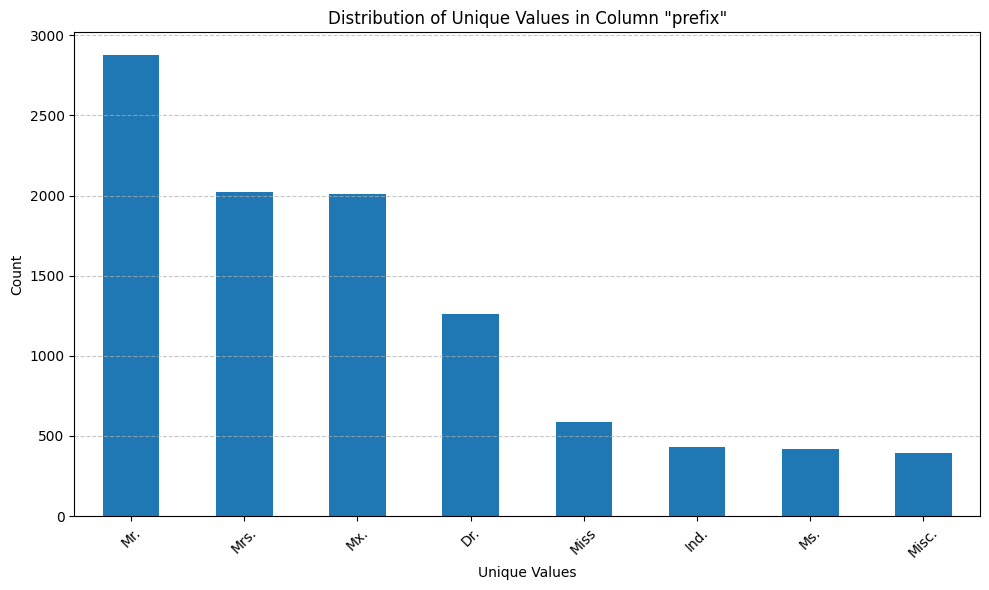

8


In [72]:
column_name = 'prefix'

unique_values_distribution = df[column_name].value_counts()

# Plot the distribution of unique values
plt.figure(figsize=(10, 6))
unique_values_distribution.plot(kind='bar')
plt.title('Distribution of Unique Values in Column "{}"'.format(column_name))
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(len(unique_values_distribution.index))

#### city ❌
?

#### country ❌  
?  
(some names are to long like “British Indian Ocean Territory (Chagos Archipelago)”, “holy see (vatican city)”, “Slovakia (Slovak Republic)”)

#### android_platform ❌  
maybe android is repeated ? (it ranges from 1 to 9 and ?)

#### user_agent ❌  
some feld have “PWNED” added randomly

#### customer_segment_code ❌  
992 missing values

#### customer_market_code ❌  
 1141 missing values and nonsense.

### Email 0 / 4

#### email_personnal ❌  
some unexpected characters ex:(hollybailey@example..org).

#### email_sso ❌  
unexpected characters ex:(paulthornton@example.Œ≥rg or craigrobe‚Ä¢ts@example.com).

#### email_vpn ❌  
unexpected characters at the end of the email adresse (​​douglasjohn@yahoo.comhg).

#### email_work ❌  
some unexpected characters ex:(jason72@!dwards-butler.info)

### Hardest - 0 / 5

#### blog_url ❌ url  
?

#### customer_uid ❌hexadecimal  
There doesn't seem to be any inherent issue with this string as a UID. However, depending on the context in which it's used, there are a few considerations:  
Uniqueness: UUIDs are typically used to uniquely identify entities. Ensure that this UUID is generated using a method that guarantees uniqueness within the intended scope (e.g., globally unique for UUIDv4).  
length: UUIDs are usually 128 bits or 32 hexadecimal characters long (excluding hyphens if present). This one seems to be of the correct length.  
Representation: Make sure the UUID is properly represented and stored in whatever system or database it's used in. For example, it might be stored as a string or a binary value depending on the requirements.  

#### xml_authent_token ❌ xml code  
?

#### profile_json ❌ json code  
?

#### cia_info_json ❌ json code  
?

# Date 0 / 6

#### dob ❌  
variation in date structure (10/7/2003 or 1987-03-58) > choose one + Customer that have more than 100 yo.

#### account_creation_date ❌  
 variation in date structure (9/21/2000 or 1999-02-29) > choose 1.

#### last_transaction_date ❌  
 hours sometimes added at the end (1/1/1970 0:00) + older than creation date ?

#### account_resiliation_date ❌  
?  
resiliation_date before creation_date ?

#### first_contact_date ❌  
inverted value between first_contact_date and last_contact_date ex: ( 02/10/1998 in first_contact_date and 12/08/1993 in last_contact_date)  

#### last_contact_date ❌  
**09**/**16**/1971 instead of **16**/**09**/1971. 

# Number 0 / 16

## Float 0 / 5

### Coordinate 0 / 3

#### latlon_home ❌  
(Decimal('-29.146587'), Decimal('-69.661657')) instead of -29.146587 latitude and -69.661657 longitude  
default value at (90, 0)  
float:  
lat -90 to 90  
long -180 to 180  

#### latlon_work ❌  
same as latlon_home except for the default coordinate being at (-27.26765, 79.60243)  
float:  
lat -90 to 90  
long -180 to 180  

#### x35_bank_branch ❌  
coordonate out of range ex: ((Decimal('99.108555'), Decimal('-30.3705825'))  
float:  
lat -90 to 90  
long -180 to 180  

## Other 0 / 2

#### credit_card_score ❌  
?

#### shoe_size ❌  
values are too precise like 41,3812748610831 and needs to be rounded to 41,5 in that case. float (with only one precision .5)

## Integer 0 / 11

### Pur Integer 0 / 9

#### salary ❌  
 there is an odd jump from 24999 to 165198,70230679.

#### first_salary ❌  
it ranges from ​​-1525444,1901449 to normal values

#### taxable_income ❌  
from -22811 to normal.

#### transaction_amount ❌  
some values seem to be shifted from 1 digit 2,992

#### credit_card_number ❌  
some cards have missing digits. integer (16 digits)

#### weight ❌  
 some really low values like 0,0118407752664808 which might be due to slippage and will need to be 118,4077 also there is no need to be that precise, 118 is enough. 

#### height ❌  
to high values 401,40395651984.

#### bank_balance ❌  
?  
the balance might be shifted from +500 since the data begins at 500.

#### zip ❌  
for the zip code to be valid it needs to be at least 5 digits and some values are lower than that. integer 5-digits

### Other ? 0 / 2

#### customer_code ❌  
?

#### customer_fico_score ❌  
?